

# 두 자산간 가격 차이를 이용한 헷징 매매 전략 지도학습
두 자산간 가격 차이를 나타낸 시계열 데이터에서 이상적인 동작 (buy=0, sell=1) 을 학습하고, 이를 예측하는 지도학습 모델.

<a id='1.1'></a>
## 1.1. 패키지 로드

In [ ]:
# 라이브러리 로드
import heapq
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense

<a id='1.2'></a>
## 1.2. 데이터 가져오기

In [ ]:
working_dir = 'data/'

# price_funding.csv에서 dataset 저장
# rawdataset = pd.read_csv(working_dir+'price_funding.csv')
rawdataset = pd.read_csv('price_funding.csv')

rawdataset.sort_values(by='timestamp', inplace=True)
rawdataset.reset_index(drop=True, inplace=True)

#경고 무시
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 2. 탐색적 데이터 분석

<a id='2.1'></a>
## 2.1. 기술 통계

In [ ]:
# 데이터셋 구조 확인
rawdataset.shape

# 데이터 확인
pd.set_option('display.width', 100)
rawdataset

,timestamp,spot_close,futures_close,price_diff,Funding Rate
0,2024-02-19 10:00:00,52349.77,52386.4,-36.63,0.000000
1,2024-02-19 11:00:00,52340.14,52386.1,-45.96,0.000000
2,2024-02-19 12:00:00,52270.65,52312.1,-41.45,0.000000
3,2024-02-19 13:00:00,52153.07,52180.9,-27.83,0.000000
4,2024-02-19 14:00:00,52098.00,52130.1,-32.10,0.000000
...,...,...,...,...,...
8755,2025-02-18 05:00:00,95616.07,95553.9,62.17,0.000000
8756,2025-02-18 06:00:00,95383.37,95340.1,43.27,0.000000
8757,2025-02-18 07:00:00,95453.70,95410.1,43.60,0.000000
8758,2025-02-18 08:00:00,95234.05,95191.1,42.95,0.000046


<a id='3'></a>
# 3. 데이터 준비

<a id='3.1'></a>
## 3.1. 데이터 청소

In [ ]:
# null 값 확인
print('Null Values =',rawdataset.isnull().values.any())

Null Values = False


nan값 있으면 dropna로 삭제하든 ffill로 보간하든 해야한다. 안하면 나중에 오류남

In [ ]:
# null 값 보간
rawdataset[rawdataset.columns.values] = rawdataset[rawdataset.columns.values].ffill()

In [ ]:
rawdataset.tail()

,timestamp,spot_close,futures_close,price_diff,Funding Rate
8755,2025-02-18 05:00:00,95616.07,95553.9,62.17,0.000000
8756,2025-02-18 06:00:00,95383.37,95340.1,43.27,0.000000
8757,2025-02-18 07:00:00,95453.70,95410.1,43.60,0.000000
8758,2025-02-18 08:00:00,95234.05,95191.1,42.95,0.000046
8759,2025-02-18 09:00:00,95634.07,95600.1,33.97,0.000000


<a id='3.3'></a>
## 3.2. 특성 엔지니어링




예측을 만들기 위한 특성들을 정의한다.

아직 이건 연구가 더 필요하다. 모델 성능에 가장 중요한 영향을 주는데, 가장 부족한 부분이다.

In [ ]:
# 가격 데이터 정의
df = rawdataset["price_diff"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 시계열 데이터를 일정한 시간 간격으로 분할
t = 100  # 원하는 시간 간격 설정 (예: 5개 데이터 포인트씩 분할)
num_segments = len(df) // t

# 세그먼트별 차이값 계산
segment_diff_values = []
cumulative_diff_values = []

# 데이터 분할 및 차이값 계산
cumulative_sum = 0
for i in range(num_segments):
    segment = df[i*t:(i+1)*t]
    segment_diff = segment.max() - segment.min()
    segment_diff_values.append(segment_diff)

    # 누적 합 계산
    cumulative_sum += segment_diff
    cumulative_diff_values.append(cumulative_sum)

# 나머지 데이터 처리 (선택적)
remainder = df[num_segments*t:]
if len(remainder) > 0:
    remainder_diff = remainder.max() - remainder.min()
    segment_diff_values.append(remainder_diff)

    # 누적 합에 나머지 세그먼트 차이 추가
    cumulative_sum += remainder_diff
    cumulative_diff_values.append(cumulative_sum)

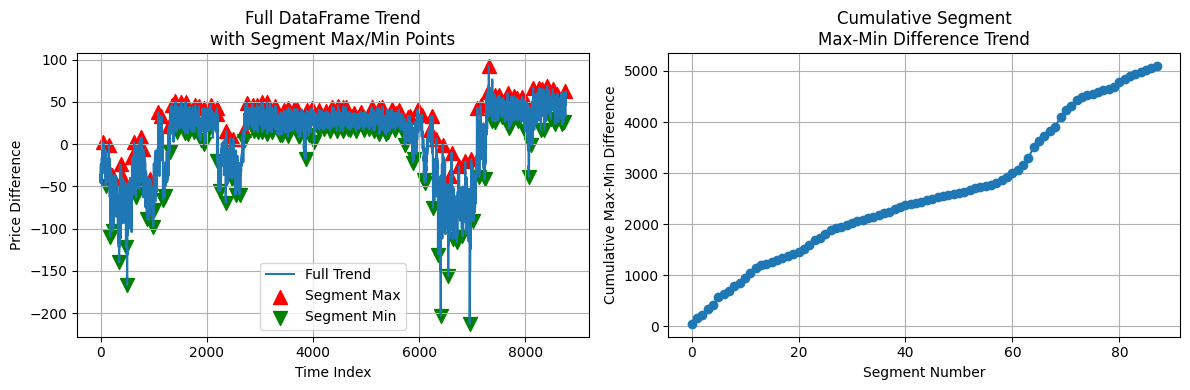

,price_diff,action
0,-36.63,0
1,-45.96,0
2,-41.45,0
3,-27.83,0
4,-32.10,0
...,...,...
8755,62.17,0
8756,43.27,0
8757,43.60,0
8758,42.95,0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 서브플롯 생성 (1행 2열)
plt.figure(figsize=(12, 4))

# 첫 번째 서브플롯 (세그먼트 최대/최소 포인트)
plt.subplot(1, 2, 1)
plt.plot(df.index, df.values, label='Full Trend')
plt.title('Full DataFrame Trend\nwith Segment Max/Min Points')
plt.xlabel('Time Index')
plt.ylabel('Price Difference')

# action 열 초기화 (0으로)
action_df = pd.DataFrame(df)
action_df["action"] = 0

for i in range(num_segments):
    segment = df[i*t:(i+1)*t]

    # 세그먼트 내 최대/최소값과 해당 인덱스 찾기
    segment_max_idx = segment.idxmax()
    segment_max_value = segment.max()
    segment_min_idx = segment.idxmin()
    segment_min_value = segment.min()

    # 최솟값과 최댓값 인덱스 사이를 action = 1로 설정
    start_idx = min(segment_max_idx, segment_min_idx)
    end_idx = max(segment_max_idx, segment_min_idx)
    action_df.loc[start_idx:end_idx, "action"] = 1

    # 시각화용 (선택)
    plt.scatter(segment_max_idx, segment_max_value, color='red', marker='^', s=100, label='Segment Max' if i==0 else "")
    plt.scatter(segment_min_idx, segment_min_value, color='green', marker='v', s=100, label='Segment Min' if i==0 else "")



# 나머지 데이터 처리 (선택적)
remainder = df[num_segments*t:]
if len(remainder) > 0:
    remainder_max_idx = remainder.idxmax()
    remainder_max_value = remainder.max()
    remainder_min_idx = remainder.idxmin()
    remainder_min_value = remainder.min()

    plt.scatter(remainder_max_idx, remainder_max_value, color='red', marker='^', s=100)
    plt.scatter(remainder_min_idx, remainder_min_value, color='green', marker='v', s=100)

plt.grid(True)
plt.legend()

# 두 번째 서브플롯 (누적 차이 트렌드)
plt.subplot(1, 2, 2)
plt.plot(range(len(cumulative_diff_values)), cumulative_diff_values, marker='o')
plt.title('Cumulative Segment\nMax-Min Difference Trend')
plt.xlabel('Segment Number')
plt.ylabel('Cumulative Max-Min Difference')
plt.grid(True)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()
action_df

In [ ]:
dataset = action_df.copy()

In [ ]:
# EMA 계산
def EMA(df, n):
    EMA = pd.Series(df['price_diff'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA1'] = EMA(dataset, 1)
dataset['EMA3'] = EMA(dataset, 3)
dataset['EMA10'] = EMA(dataset, 10)
dataset.head()

# 모멘텀 (MOM) 계산
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM1'] = MOM(dataset['price_diff'], 1)
dataset['MOM3'] = MOM(dataset['price_diff'], 3)
dataset['MOM3'] = MOM(dataset['price_diff'], 10)

#상대강도지수 (RSI) 계산
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI1'] = RSI(dataset['price_diff'], 1)
dataset['RSI3'] = RSI(dataset['price_diff'], 3)
dataset['RSI10'] = RSI(dataset['price_diff'], 10)

# 이동평균 (MA) 계산
def MA(df, n):
    MA = pd.Series(df['price_diff'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA1'] = MA(dataset, 1)
dataset['MA3'] = MA(dataset, 3)
dataset['MA10'] = MA(dataset, 10)

def Price_EMA_Diff(df, n):
    ema = df['price_diff'].ewm(span=n, min_periods=n).mean()
    diff = df['price_diff'] - ema
    return pd.Series(diff, name=f'Price_EMA_Diff_{n}')

dataset['PEMA1'] = Price_EMA_Diff(dataset, 1)
dataset['PEMA3'] = Price_EMA_Diff(dataset, 3)
dataset['PEMA10'] = Price_EMA_Diff(dataset, 10)

def CCI(df, n):
    ma = df['price_diff'].rolling(window=n).mean()
    md = df['price_diff'].rolling(window=n).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    cci = (df['price_diff'] - ma) / (0.015 * md)
    return pd.Series(cci, name=f'CCI_{n}')

dataset['CCI3'] = CCI(dataset, 3)
dataset['CCI10'] = CCI(dataset, 10)

def WilliamsR(series, n):
    high = series.rolling(window=n).max()
    low = series.rolling(window=n).min()
    r = -100 * (high - series) / (high - low)
    return pd.Series(r, name=f'WilliamsR_{n}')

dataset['WILLR3'] = WilliamsR(dataset['price_diff'], 3)
dataset['WILLR10'] = WilliamsR(dataset['price_diff'], 10)

def STDDEV(df, n):
    std = df['price_diff'].rolling(window=n).std()
    return pd.Series(std, name=f'STD_{n}')

dataset['STD3'] = STDDEV(dataset, 3)
dataset['STD10'] = STDDEV(dataset, 10)

def ZScore(df, n):
    ma = df['price_diff'].rolling(window=n).mean()
    std = df['price_diff'].rolling(window=n).std()
    z = (df['price_diff'] - ma) / std
    return pd.Series(z, name=f'ZScore_{n}')

dataset['Z3'] = ZScore(dataset, 3)
dataset['Z10'] = ZScore(dataset, 10)

def MACD(series, fast=12, slow=26, signal=9, prefix=''):

    ema_fast = series.ewm(span=fast, min_periods=fast).mean()
    ema_slow = series.ewm(span=slow, min_periods=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=signal).mean()
    histogram = macd_line - signal_line

    if prefix:
        prefix = f"{prefix}_"

    return pd.DataFrame({
        f'{prefix}MACD_{fast}_{slow}_{signal}': macd_line,
        f'{prefix}MACD_Signal_{fast}_{slow}_{signal}': signal_line,
        f'{prefix}MACD_Hist_{fast}_{slow}_{signal}': histogram
    })

macd_df = MACD(dataset['price_diff'])
dataset = pd.concat([dataset, macd_df], axis=1)

macd_params = [
    {'fast': 5, 'slow': 15, 'signal': 5, 'prefix': 'Short'},
    {'fast': 10, 'slow': 20, 'signal': 7, 'prefix': 'Med'},
    {'fast': 15, 'slow': 30, 'signal': 10, 'prefix': 'Long'},
    {'fast': 3, 'slow': 10, 'signal': 3, 'prefix': 'UltraShort'},
    {'fast': 20, 'slow': 40, 'signal': 15, 'prefix': 'UltraLong'}
]

for params in macd_params:
    macd_variant = MACD(dataset['price_diff'], **params)
    dataset = pd.concat([dataset, macd_variant], axis=1)

print(f"추가된 MACD 지표: {len(macd_params) + 1}개")
print("MACD 관련 컬럼:")

macd_columns = [col for col in dataset.columns if 'MACD' in col]

for col in macd_columns:
    print(f"  - {col}")

def Bollinger_Bands(series, n=20, k=2):
    ma = series.rolling(window=n).mean()
    std = series.rolling(window=n).std()
    upper = ma + (k * std)
    lower = ma - (k * std)
    return pd.DataFrame({
        f'BB_MA_{n}': ma,
        f'BB_Upper_{n}': upper,
        f'BB_Lower_{n}': lower
    })

bb_df = Bollinger_Bands(dataset['price_diff'], n=20, k=2)
dataset = pd.concat([dataset, bb_df], axis=1)

def StochRSI(series, period=14):
    rsi = RSI(series, period).dropna()
    stoch_rsi = (rsi - rsi.rolling(window=period).min()) / \
                (rsi.rolling(window=period).max() - rsi.rolling(window=period).min())
    return pd.Series(stoch_rsi, name=f'StochRSI_{period}')

dataset['StochRSI14'] = StochRSI(dataset['price_diff'], 14)


추가된 MACD 지표: 6개
MACD 관련 컬럼:
  - MACD_12_26_9
  - MACD_Signal_12_26_9
  - MACD_Hist_12_26_9
  - Short_MACD_5_15_5
  - Short_MACD_Signal_5_15_5
  - Short_MACD_Hist_5_15_5
  - Med_MACD_10_20_7
  - Med_MACD_Signal_10_20_7
  - Med_MACD_Hist_10_20_7
  - Long_MACD_15_30_10
  - Long_MACD_Signal_15_30_10
  - Long_MACD_Hist_15_30_10
  - UltraShort_MACD_3_10_3
  - UltraShort_MACD_Signal_3_10_3
  - UltraShort_MACD_Hist_3_10_3
  - UltraLong_MACD_20_40_15
  - UltraLong_MACD_Signal_20_40_15
  - UltraLong_MACD_Hist_20_40_15


In [ ]:
dataset.tail()

,price_diff,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,...,UltraShort_MACD_3_10_3,UltraShort_MACD_Signal_3_10_3,UltraShort_MACD_Hist_3_10_3,UltraLong_MACD_20_40_15,UltraLong_MACD_Signal_20_40_15,UltraLong_MACD_Hist_20_40_15,BB_MA_20,BB_Upper_20,BB_Lower_20,StochRSI14
8755,62.17,0,62.17,56.439501,51.482436,9.97,24.99,100.0,85.564232,60.453745,...,4.957065,3.016086,1.940979,1.166647,0.478985,0.687662,49.1960,64.048821,34.343179,1.00000
8756,43.27,0,43.27,49.854750,49.989266,-18.90,-9.33,0.0,32.274595,45.713044,...,-0.134515,1.440786,-1.575301,0.805574,0.519809,0.285765,48.6510,63.535228,33.766772,0.14339
8757,43.60,0,43.60,46.727375,48.827581,0.33,-1.71,100.0,33.361568,45.968637,...,-2.100206,-0.329710,-1.770496,0.506413,0.518134,-0.011721,47.9195,62.249224,33.589776,0.15823
8758,42.95,0,42.95,44.838688,47.758930,-0.65,-7.53,0.0,31.851197,45.499801,...,-2.920242,-1.624976,-1.295266,0.216398,0.480417,-0.264020,48.3405,61.457320,35.223680,0.13010
8759,33.97,0,33.97,39.404344,45.251852,-8.98,-15.66,0.0,16.433466,39.340639,...,-5.847508,-3.736242,-2.111266,-0.451393,0.363941,-0.815334,48.2840,61.648357,34.919643,0.00000


In [ ]:
# 무한대 값 검사
is_inf = dataset.isin([np.inf, -np.inf])

inf_count_per_column = is_inf.sum()
rows_with_inf = dataset[is_inf.any(axis=1)]
print("무한대가 포함된 행:\n", rows_with_inf)

무한대가 포함된 행:
 Empty DataFrame
Columns: [price_diff, action, EMA1, EMA3, EMA10, MOM1, MOM3, RSI1, RSI3, RSI10, MA1, MA3, MA10, PEMA1, PEMA3, PEMA10, CCI3, CCI10, WILLR3, WILLR10, STD3, STD10, Z3, Z10, MACD_12_26_9, MACD_Signal_12_26_9, MACD_Hist_12_26_9, Short_MACD_5_15_5, Short_MACD_Signal_5_15_5, Short_MACD_Hist_5_15_5, Med_MACD_10_20_7, Med_MACD_Signal_10_20_7, Med_MACD_Hist_10_20_7, Long_MACD_15_30_10, Long_MACD_Signal_15_30_10, Long_MACD_Hist_15_30_10, UltraShort_MACD_3_10_3, UltraShort_MACD_Signal_3_10_3, UltraShort_MACD_Hist_3_10_3, UltraLong_MACD_20_40_15, UltraLong_MACD_Signal_20_40_15, UltraLong_MACD_Hist_20_40_15, BB_MA_20, BB_Upper_20, BB_Lower_20, StochRSI14]
Index: []

[0 rows x 46 columns]


In [ ]:
dataset = dataset.dropna(axis=0)
dataset

,price_diff,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,...,UltraShort_MACD_3_10_3,UltraShort_MACD_Signal_3_10_3,UltraShort_MACD_Hist_3_10_3,UltraLong_MACD_20_40_15,UltraLong_MACD_Signal_20_40_15,UltraLong_MACD_Hist_20_40_15,BB_MA_20,BB_Upper_20,BB_Lower_20,StochRSI14
53,-17.23,1,-17.23,-15.883515,-11.414467,7.40,-5.27,100.0,38.865819,47.323265,...,-4.469049,-2.366674,-2.102374,4.518607,4.808355,-0.289748,-11.9865,3.766943,-27.739943,0.243941
54,-5.20,1,-5.20,-10.541758,-10.284546,12.03,2.22,100.0,63.343624,55.076661,...,-0.257212,-1.311943,1.054731,4.652631,4.786283,-0.133652,-11.2810,4.354859,-26.916859,0.597911
55,-0.89,1,-0.89,-5.715879,-8.576424,4.31,1.32,100.0,69.834481,57.563143,...,2.860545,0.774301,2.086244,4.934330,4.806921,0.127408,-10.9555,5.280082,-27.191082,0.714695
56,-2.87,1,-2.87,-4.292939,-7.538881,-1.98,11.73,0.0,62.239950,55.981518,...,3.245942,2.010121,1.235820,5.066895,4.842647,0.224248,-10.3395,6.152458,-26.831458,0.643365
57,-9.81,1,-9.81,-7.051470,-7.951815,-6.94,-7.85,0.0,39.598796,50.570174,...,0.900346,1.455233,-0.554888,4.852582,4.843996,0.008586,-9.5375,5.250603,-24.325603,0.397544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,62.17,0,62.17,56.439501,51.482436,9.97,24.99,100.0,85.564232,60.453745,...,4.957065,3.016086,1.940979,1.166647,0.478985,0.687662,49.1960,64.048821,34.343179,1.000000
8756,43.27,0,43.27,49.854750,49.989266,-18.90,-9.33,0.0,32.274595,45.713044,...,-0.134515,1.440786,-1.575301,0.805574,0.519809,0.285765,48.6510,63.535228,33.766772,0.143390
8757,43.60,0,43.60,46.727375,48.827581,0.33,-1.71,100.0,33.361568,45.968637,...,-2.100206,-0.329710,-1.770496,0.506413,0.518134,-0.011721,47.9195,62.249224,33.589776,0.158230
8758,42.95,0,42.95,44.838688,47.758930,-0.65,-7.53,0.0,31.851197,45.499801,...,-2.920242,-1.624976,-1.295266,0.216398,0.480417,-0.264020,48.3405,61.457320,35.223680,0.130100


<a id='3.4'></a>
## 3.3. 데이터 시각화

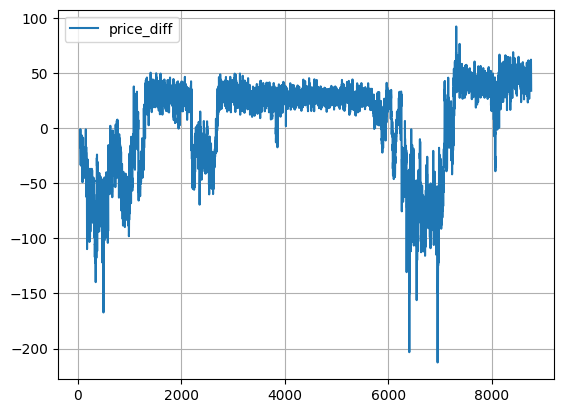

In [ ]:
# 트렌드
dataset[['price_diff']].plot(grid=True)
plt.show()

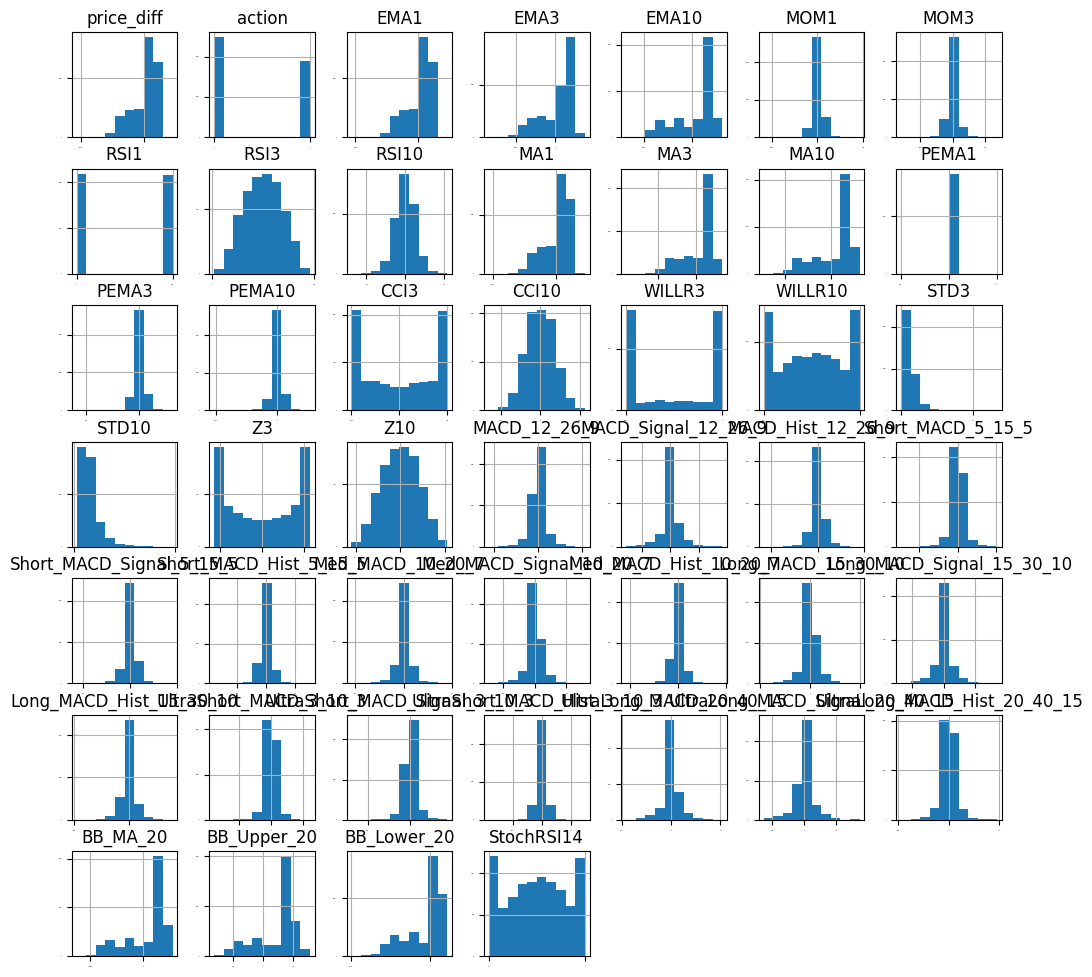

In [ ]:
# 히스토그램
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

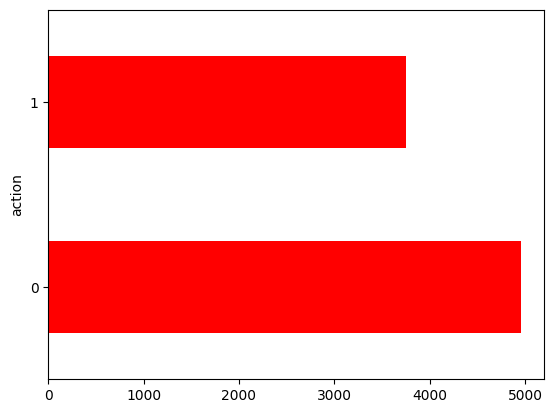

In [ ]:
# 행동들 간 비율
fig = plt.figure()
plot = dataset.groupby(['action']).size().plot(kind='barh', color='red')
plt.show()

KeyboardInterrupt: 

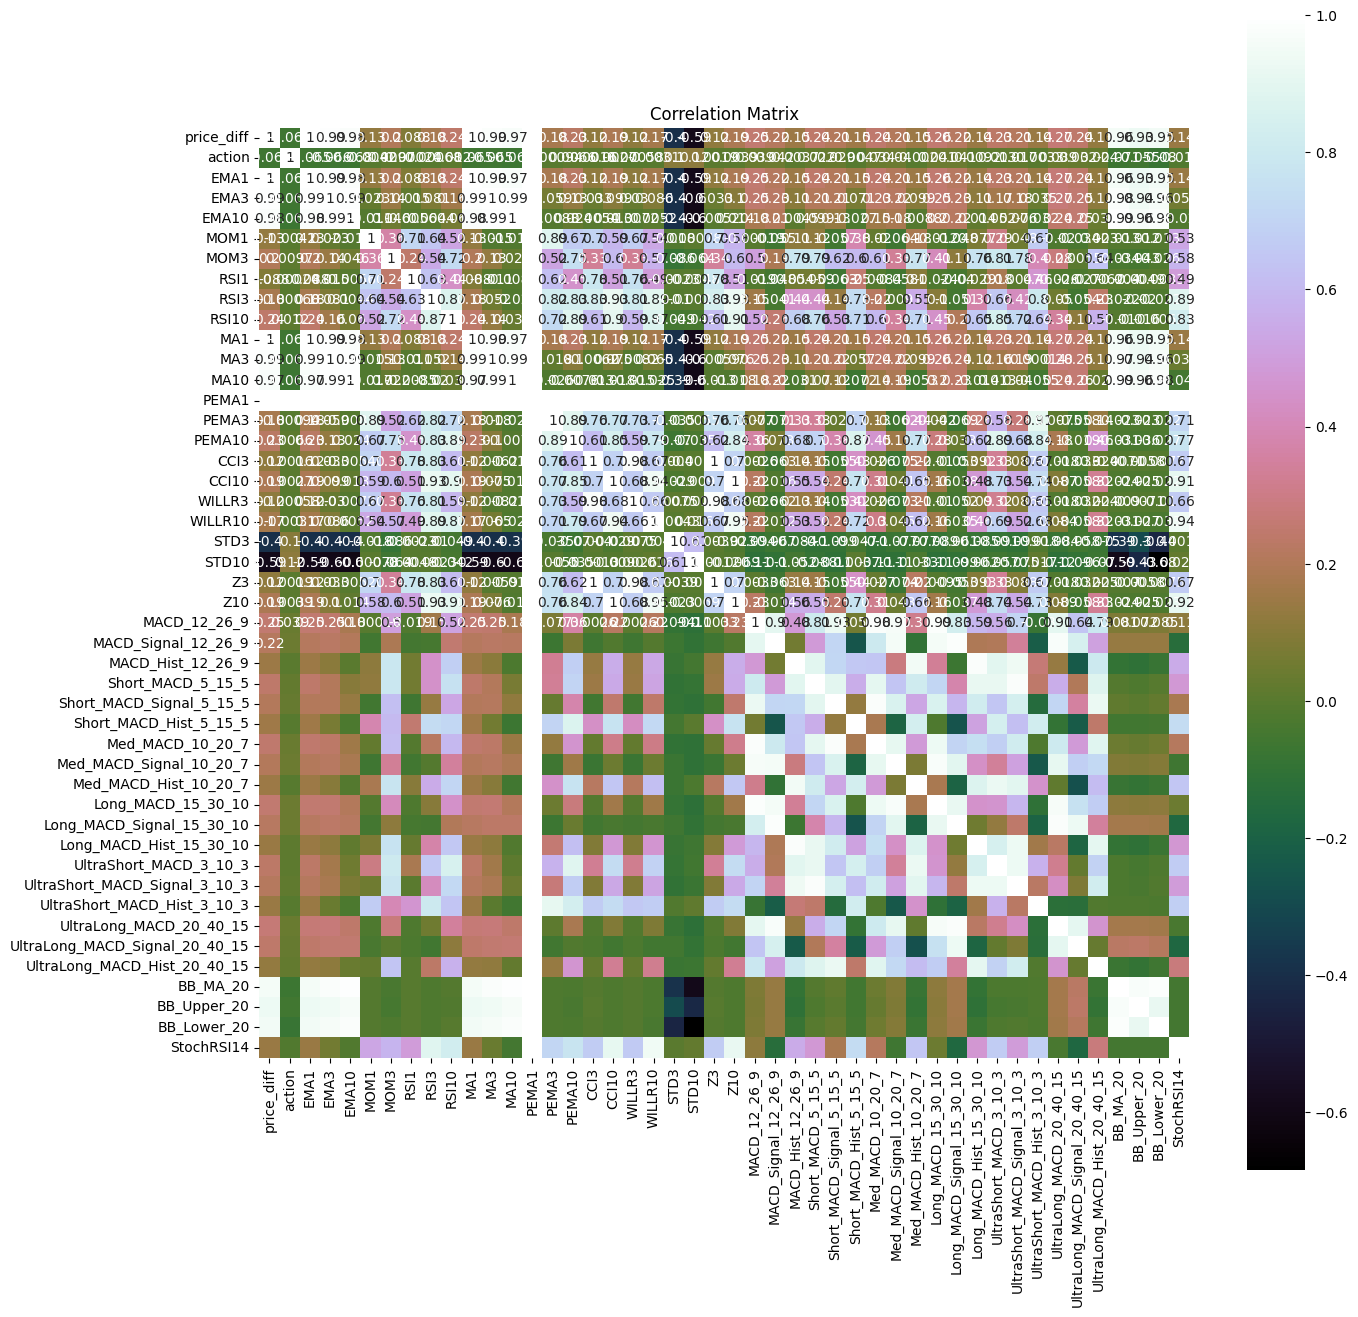

In [ ]:
# 상관계수
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 4. 알고리즘 및 모델 평가

<a id='4.1'></a>
## 4.1. train test 분리

80퍼는 학습셋으로, 20퍼는 평가셋으로

In [ ]:
subset_dataset= dataset
Y= subset_dataset["action"]
X = subset_dataset.loc[:, dataset.columns != 'action']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 4.2. 테스트 옵션 및 평가 지표


In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 4.3. 모델 및 알고리즘 비교

<a id='4.3.1'></a>
### 4.3.1. 모델 정의

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### 4.3.2. K-겹 교차 검증

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.579845 (0.023413)
LDA: 0.586735 (0.015058)
KNN: 0.563613 (0.017145)
CART: 0.728172 (0.011851)
NB: 0.575531 (0.019103)
NN: 0.593336 (0.015804)
AB: 0.618895 (0.019977)
GBM: 0.688970 (0.012907)
RF: 0.759189 (0.016671)


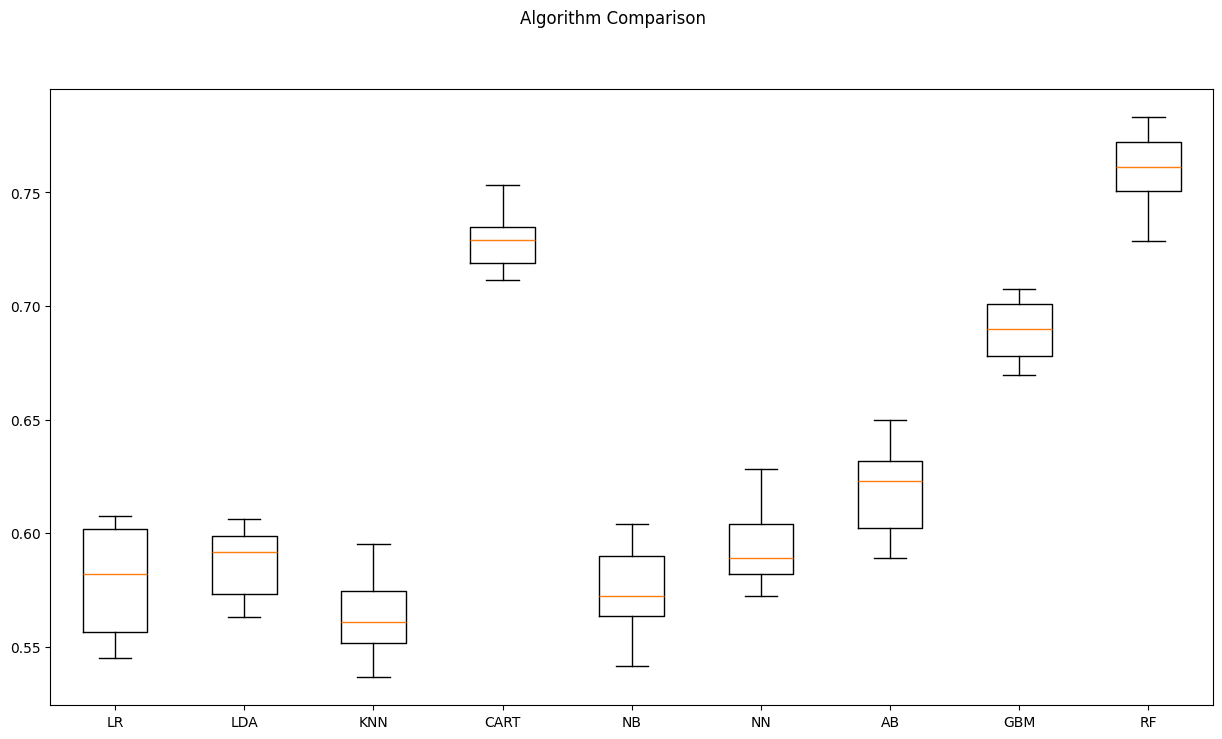

In [ ]:
# 알고리즘 비교
# results.append([accuracy_keras] * len(results[0]))  # accuracy_keras 값을 모든 항목에 추가 (같은 값 반복)
# names.append('Keras')
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 5. 그리드 서치 & 베이지안 최적화를 통한 모델 튜닝

In [ ]:
# 랜덤 포레스트 그리드 서치
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

KeyboardInterrupt: 

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.1 MB/s eta 0:00:00


In [ ]:
# 랜덤 포레스트 베이지안 최적화
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

param_space = {
    'n_estimators': Integer(300, 400),
    'max_depth': Integer(40, 50),
    'criterion': Categorical(['gini', 'entropy'])
}

model = RandomForestClassifier(n_jobs=-1, random_state=seed)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=12,
    scoring=scoring,
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=seed,
    return_train_score=True
)

bayes_result = bayes_search.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (bayes_result.best_score_, bayes_result.best_params_))
means = bayes_result.cv_results_['mean_test_score']
stds = bayes_result.cv_results_['std_test_score']
params = bayes_result.cv_results_['params']
ranks = bayes_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


KeyboardInterrupt: 

<a id='6'></a>
# 6. 최적 모델 정의

<a id='6.1'></a>
## 6.1. 테스트셋에서의 성능 평가

In [ ]:
model = RandomForestClassifier(criterion='entropy', n_estimators=400,max_depth=20,n_jobs=-1)
model.fit(X_train, Y_train)
# model = LogisticRegression()
# model = create_nn()
# model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=1)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=400,
                       n_jobs=-1)

In [ ]:
predictions = model.predict(X_validation)
# predictions = (model.predict(X_validation) > 0.5).astype(int)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7794371051120046
[[878 108]
 [276 479]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       986
           1       0.82      0.63      0.71       755

    accuracy                           0.78      1741
   macro avg       0.79      0.76      0.77      1741
weighted avg       0.78      0.78      0.77      1741



<Axes: xlabel='Predicted', ylabel='Actual'>

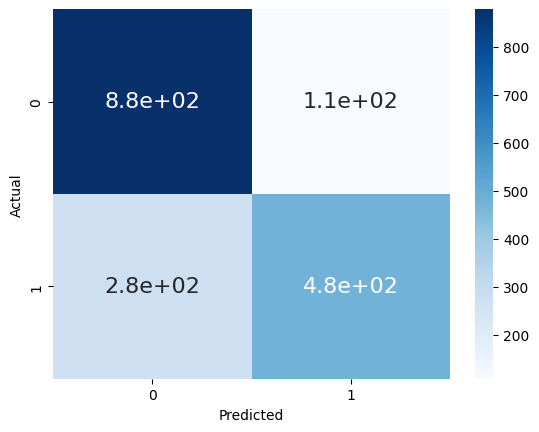

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

<a id='6.2'></a>
## 6.2. 변수 및 특성 중요도
모델에서 가장 중요한 특성 및 변수를 알아보자

Text(0.5, 0, 'Variable Importance')

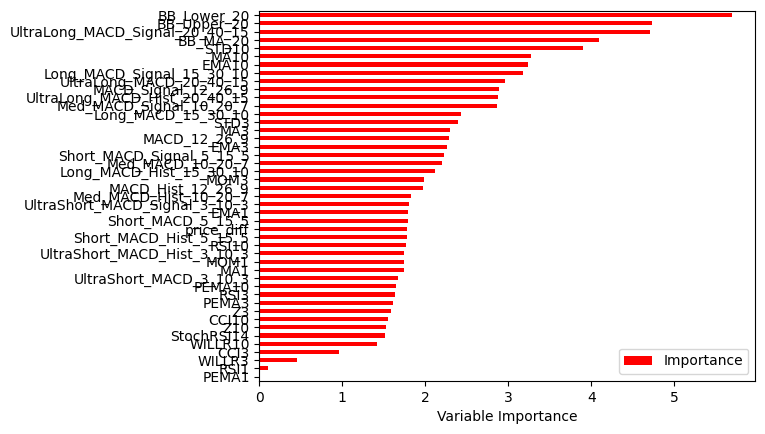

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 7. 결과 백테스트

<Axes: >

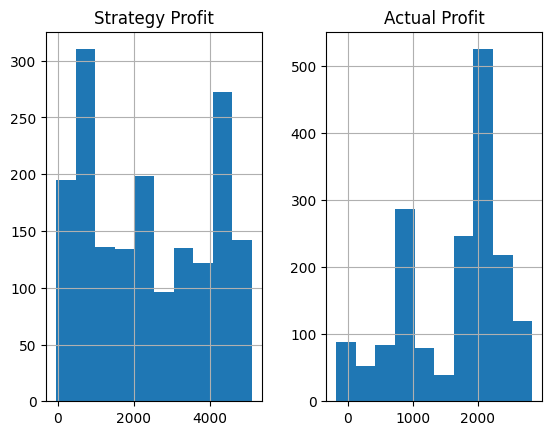

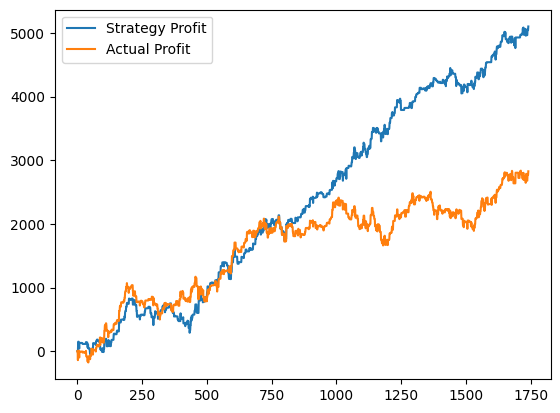

In [ ]:
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['action_pred'] = predictions
backtestdata['action_actual'] = Y_validation
# backtestdata['Market Returns'] = X_validation['Price'].pct_change()
# backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['action_actual'].shift(1)
# backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['action_pred'].shift(1)
backtestdata['Market Profit'] = X_validation['price_diff'].diff()
backtestdata['Strategy Profit'] = backtestdata['Market Profit'] * (backtestdata['action_pred'].shift(1) == 1)
backtestdata['Actual Profit'] = backtestdata['Market Profit'] * (backtestdata['action_actual'].shift(1) == 1)

backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().hist()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().plot()